# TP - Système de ressorts

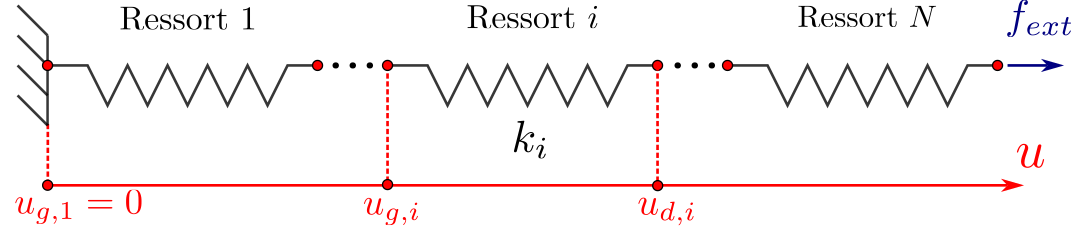

On s'intéresse à un système de $N$ ressorts en série. Il s'agit donc d'un problème 1D avec un nombre de degré de liberté $n_{dof} = N+1$.

L'énergie potentielle $E^p_i$ du système associée au ressort $i$ s'écrit :
$$
E^p_i
=
\frac{1}{2} k_i(u_{d, i} - u_{g, i})^2
$$
avec $k_i$ la rigidité du ressort et $u_{d,i}$ (resp. $u_{g,i}$) le déplacement de l'extrémité gauche (resp. droite) du ressort. On peut réécrire cette équation de façon matricielle : 
$$
E^p_i = \frac{1}{2}\mathbf U_i^T\cdot \mathbf K_i\cdot\mathbf U_i
$$
avec : 
$$
\mathbf U_i
=
\begin{pmatrix}
u_{g, i}\\
u_{d, i}
\end{pmatrix},
$$
$$
\mathbf K_i
=
\begin{pmatrix}
k_i & -k_i\\
-k_i & k_i
\end{pmatrix}.
$$
Physiquement, cette énergie **interne** est égale au travail des forces **externes** $\mathbf F_i \cdot \mathbf U_i$. Cette quantité sera nulle partout, à l'exception du noeud à l'extrémité droite du système où on applique l'effort $f_{ext}$. On a donc :
$$
\frac{1}{2}\mathbf U_i^T\cdot \mathbf K_i\cdot\mathbf U_i
=
\mathbf F_i \cdot \mathbf U_i
$$
En dérivant par rapport à $\mathbf U$, on obtient le problème élémentaire associé à l'élement $i$ : 
$$
\mathbf K_i\cdot\mathbf U_i
=
\mathbf F_i
$$
À partir du problème élémentaire, on construit ensuite le problème global de la forme :
$$
\mathbf K\cdot\mathbf U
=
\mathbf F.
$$
Cela constitue la phase d'**assemblage** du problème global. Une des méthodes est de passer par une **table des connectivités** $L$. Celle-ci liste pour chaque élément les noeuds qui lui sont associés. Dans le cas présent, celle-ci aura une forme simple : l'élément ressort $i$ est associé au noeud $i$ et $i+1$. Donc : 
$$
L(\text{element i})
=
[i,\, i+1]
$$
Dans notre implémentation, on ajoutera à cette liste la raideur $k_i$, associée à l'élement $i$ (i.e. raideur entre les points $i$ et $i+1$). Cette raideur fera appel à une fonction $k$ :
$$
k_i = k(x_i)
$$
de telle sorte à généraliser simplement les cas où les $k_i$ sont constants, variables,...

On ajoutera ensuite les matrices élémentaires $\mathbf K_i$ aux "bons endroits" (grâce à la table de connectivité) à la matrice globale $\mathbf K$ initialement nulle. On construit ainsi la matrice de rigidité globale $\mathbf K$ élément par élément. Finalement, le coefficient $K_{ij}$ mesure à quel point le déplacement du point $i$ influe celui du point $j$. Généralement, cette action étant "réciproque" donc $K_{ij}=K_{ji}$ : la matrice de rigidité est symétrique. Les coefficients $K_{ii}$ peuvent être vus comme la résistance intrinsèque du noeud $i$ au déplacement.

Comme indiqué précédemment les composantes du vecteur $\mathbf F$ seront nulles partout, sauf pour le noeud associée à l'extrémité droite du système où on aura $f_{ext}$ :
$$
F_j =
\left \{
\begin{matrix}
f{ext} & \text{pour} & j=n_{dof},\\
0 & \text{sinon}.
\end{matrix}
\right .
$$

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as la

In [15]:
def compute_K_elem(ki) :
    K_elem = np.array([[1., -1.],[-1., 1.]])
    return ki*K_elem

def compute_K_F(n_dof, connectivity_table, f_ext):
    K = np.zeros((n_dof, n_dof))
    F = np.zeros((n_dof, 1))
    F[-1] = f_ext
    
    for index_1, index_2, ki in connectivity_table : 
        K_elem = compute_K_elem(ki)
        K[np.ix_([index_1, index_2],[index_1, index_2])] += K_elem
        
    return K, F

def compute_connectivity_table(n_dof):
    n_elem = n_dof - 1
    return [[i, i+1, k_function(i)] for i in range(n_elem)]


In [16]:
n_dof = 3
f_ext = 2
k_function = lambda x : 1.

connectivity_table = compute_connectivity_table(n_dof)
K, F = compute_K_F(n_dof, connectivity_table, f_ext)
U = la.solve(K, F)

LinAlgError: Singular matrix

On constate que tel quel le système n'est pas soluble car la matrice $\mathbf K$ n'est pas inversible. On peut vérifier cela en calculant numériquement son **déterminant** $\det (\mathbf A)$, qui est nul. Ce comportement s'explique physiquement : la condition au limite sur l'extrémité gauche n'est pas encore été traitée : le problème présente un **mouvement de corps rigide** qui ne permet pas de fixer la solution. Il faut donc traiter :
$$
x_1(0) = 0.
$$
Plusieurs solutions permettent de traiter la prise en compte des conditions aux limites de ce type. En première approche, on peut choisir de forcer directement cette condition dans la matrice de rigidité. Pour cela, on modifie la ligne associée dans le système, en l'occurrence la première. Le système devient : 
$$
\begin{pmatrix}
1 & 0 & \cdots & 0\\ \hline
&\text{inchangé}&&
\end{pmatrix}
\cdot 
\begin{pmatrix}
x_1\\
\vdots \\
x_{n_{dof}}
\end{pmatrix}
= 
\begin{pmatrix}
0\\ \hline
\text{inchangé}
\end{pmatrix}.
$$
Le développement de la première ligne permet bien de retrouver la condition. Cette méthode nécessite de modifier une ligne entière : nous verrons par la suite une méthode moins intrusive.

In [17]:
def apply_boundary_condition(K, F):
    position_boundary_cdt = 0
    K[position_boundary_cdt, :] = 0
    K[position_boundary_cdt, position_boundary_cdt] = 1

Text(0, 0.5, 'Displacement')

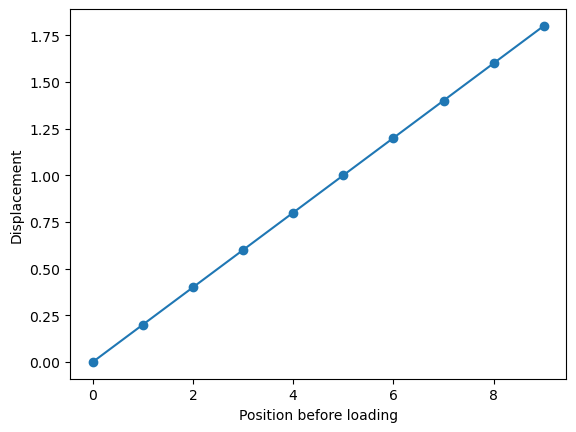

In [18]:
n_dof = 10
f_ext = 2
k_function = lambda x : 10.

connectivity_table = compute_connectivity_table(n_dof)
K, F = compute_K_F(n_dof, connectivity_table, f_ext)
apply_boundary_condition(K, F)
U = la.solve(K, F)

plt.plot(U, "o-")
plt.xlabel("Position before loading")
plt.ylabel("Displacement")

On retrouve bien un déplacement linéaire qui aurait pu être pressenti compte tenu de la linéarité du problème global et de la constance des coefficients. On peut alors jouer avec la raideur pour observer comment le comportement global est affecté.

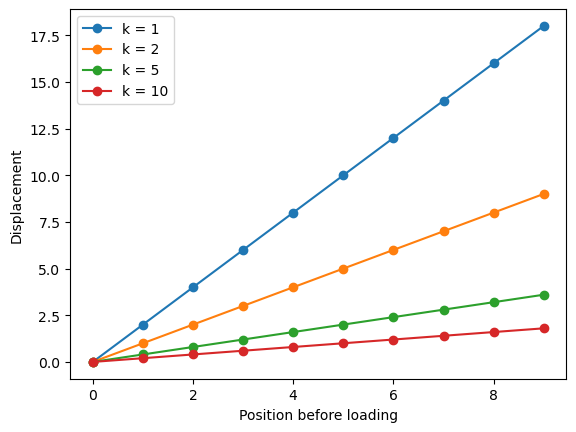

In [19]:
n_dof = 10
f_ext = 2

k_list = [1, 2, 5, 10]

for k in k_list:
    k_function = lambda x : k

    connectivity_table = compute_connectivity_table(n_dof)
    K, F = compute_K_F(n_dof, connectivity_table, f_ext)
    apply_boundary_condition(K, F)
    U = la.solve(K, F)

    plt.plot(U, "o-", label="k = "+str(k))
    
plt.xlabel("Position before loading")
plt.ylabel("Displacement")
plt.legend()

On voit naturellement que plus la raideur augmente moins le déplacement engendré sera important. On peut choisir maintenant de faire varier la raideur linéairement : allant de gauche à droite, les ressorts sont de plus en plus raides :
$$
k_i = k(x_i)
=
k_0 (1 + x_i)
$$

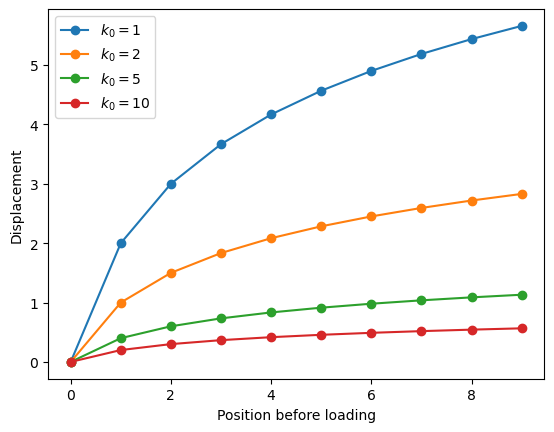

In [20]:
n_dof = 10
f_ext = 2

k_list = [1, 2, 5, 10]

for k in k_list:
    k_function = lambda x : k*(1 + x)

    connectivity_table = compute_connectivity_table(n_dof)
    K, F = compute_K_F(n_dof, connectivity_table, f_ext)
    apply_boundary_condition(K, F)
    U = la.solve(K, F)

    plt.plot(U, "o-", label="$k_0 = $"+str(k))
    
plt.xlabel("Position before loading")
plt.ylabel("Displacement")
plt.legend()

On voit bien qu'on perd la solution linéaire, le déplacement étant de plus en plus petit au fur et mesure que la raideur augmente.

On constate que la matrice de rigidité globale ne contient un grand nombre de zéro : on parle de matrice **creuse**. On réprésente ici où sont les termes non nuls dans la matrice.

Text(0, 0.5, 'Colomn')

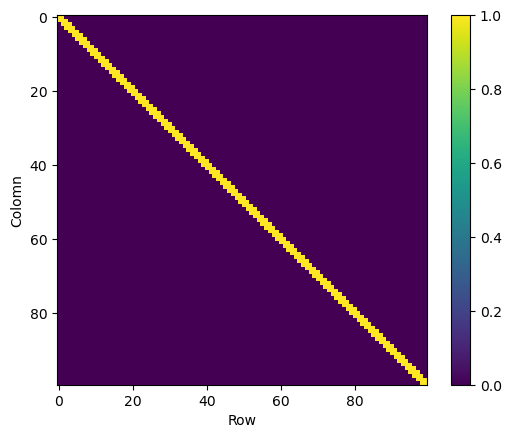

In [21]:
n_dof = 100
f_ext = 2

connectivity_table = compute_connectivity_table(n_dof)
K, F = compute_K_F(n_dof, connectivity_table, f_ext)
    
K_binary = np.where(K != 0, 1, 0)

plt.imshow(K_binary)
plt.colorbar()
plt.xlabel("Row")
plt.ylabel("Colomn")

On voit que les termes non nuls sont localisés autour de la diagonale. Cela est dû au fait que le noeud $i$ interagit seulement avec ses voisins : seuls les $K_{i,i}, K_{i, i-1}, K_{i, i+1}$ (et symétriquement $K_{i-1, i}, K_{i+1, i}$) sont non-nuls. On appelle généralement la largeur dans laquelle sont présents les termes non-nuls, la **largeur de bande** de la matrice. Plus elle est grande, plus des points éloignés interagissent entre eux et plus on s'éloigne d'un système diagonal : le système est alors plus dur à inverser.  

Une manière d'augmenter cette largeur de bande est de rajouter des ressorts en parallèle qui viendront connecter des noeuds $i$ et $j$ qui ne seront pas forcément voisins. Cet ajout est quasiment transparent en termes de code si on s'appuie sur la table de connectivité (on voit ici un de ses intérêt!). Il suffira simplement de rajouter des termes supplémentaires à la table :
$$
L_{parallel}(\text{element } e') = [i, j]
$$
On choisira ici de rajouter un ressort qui tous les noeuds $i$ au noeud $i+\text{offset}$. Plus l'offset est grand, plus la largeur de bande augmentera, ce qui est illustré dans le code suivant.

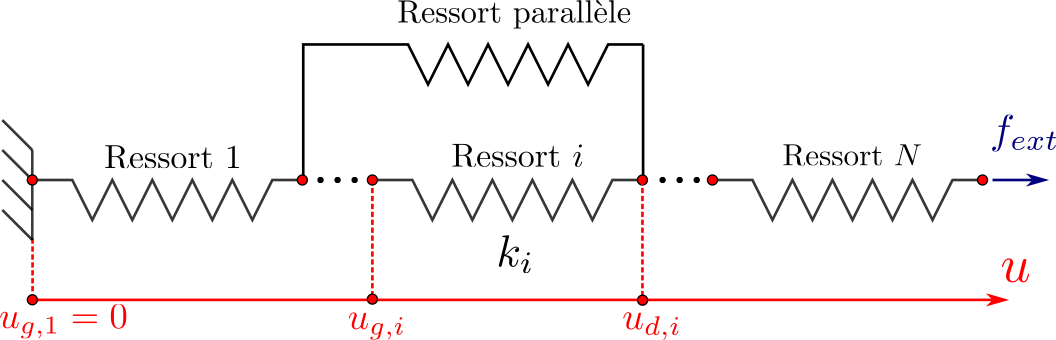

In [22]:
def add_parallel_spring(connectivity_table, offset):
    connectivity_table += [[i, i + offset, k_parallel_function(i)] for i in range(n_dof - offset)]
    return connectivity_table

Text(0, 0.5, 'Colomn')

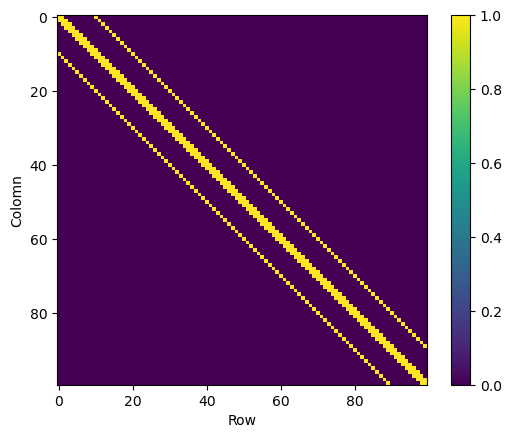

In [23]:
n_dof = 100
f_ext = 2
offset = 10

k_function = lambda x : 1.
k_parallel_function = lambda x : 1.

connectivity_table = compute_connectivity_table(n_dof)
add_parallel_spring(connectivity_table, offset)

K, F = compute_K_F(n_dof, connectivity_table, f_ext)

K_binary = np.where(K != 0, 1, 0)

plt.imshow(K_binary)
plt.colorbar()
plt.xlabel("Row")
plt.ylabel("Colomn")

Cet ajout modifie logiquement le champ de déplacement solution.

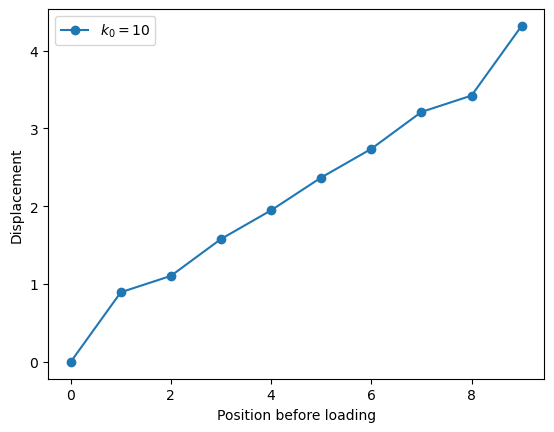

In [28]:
n_dof = 10
f_ext = 2
offset = 2

k_function = lambda x : 1.
k_parallel_function = lambda x : 1.

connectivity_table = compute_connectivity_table(n_dof)
add_parallel_spring(connectivity_table, offset)

K, F = compute_K_F(n_dof, connectivity_table, f_ext)

apply_boundary_condition(K, F)
U = la.solve(K, F)

plt.plot(U, "o-", label="$k_0 = $"+str(k))
    
plt.xlabel("Position before loading")
plt.ylabel("Displacement")
plt.legend()

Comme illustré précédemment la matrice de rigidité est creuse. Il est donc pertinent d'employer une structure de donnée adaptée à ce type de matrice. On utilisera alors un stockage **sparse** qui part du principe que les coefficients sont nuls par défaut et on stockera seulement les coefficients non-nuls. L'emploi de ce type de structure permet des gains d'espace conséquents. On peut alors traiter des tailles de problèmes qu'on ne pourrait pas aborder avec la méthode précédente, faute d'espace.

En pratique, la bibliothèque Scipy possède un package sparse (scipy.sparse) et une algèbre linéaire adpatée (scipy.sparse.linalg) qu'on utilisera ici. Néanmoins, la manipulation des matrices sparse est un peu moins flexible que les np.array précédent. Il faudra alors modifier l'assemblage et l'application des conditions aux limites en fonction. 

On utilisera une autre méthode pour l'application de la condition au limite sur le déplacement. La méthode précédente nécessitait de modifier une ligne entière après coup, ce qui n'est pas très adaptée au matrice sparse. On préférera ici utiliser une méthode par **pénalisation**. L'idée est d'introduire  un coefficient $\alpha$ très grand :
$$
\alpha \gg max(K_{ij}).
$$
En supposant qu'on veuille imposer $x_1 = x_1^{imp}$, le système est alors : 
$$
\begin{pmatrix}
\alpha + K_{11}  &\cdots & K_{1 n_{dof}}\\ \hline
&\text{inchangé}&&
\end{pmatrix}
\cdot 
\begin{pmatrix}
x_1\\
\vdots \\
x_{n_{dof}}
\end{pmatrix}
= 
\begin{pmatrix}
\alpha x_1^{imp} \\ \hline
\text{inchangé}
\end{pmatrix}.
$$
Le développement de la première ligne donne alors :
$$
\alpha x_1^{imp} =
(\alpha + K_{11}) x_1 + \cdots
+ 
K_{1 n_{dof}} x_{n_{dof}}
\approx 
\alpha 
x_1
$$
On retrouve bien la condition à imposer en ayant seulement introduit le terme $\alpha$ à deux endroits du système.

In [29]:
def compute_K_F_sparse(n_dof, connectivity_table, f_ext):
    F = np.zeros((n_dof, 1))
    F[-1] = f_ext
    
    row_idx = list()
    col_idx = list()
    data = list()
    
    for index_1, index_2, ki in connectivity_table : 
        K_elem = compute_K_elem(ki)
        row_idx += [index_1, index_1, index_2, index_2]
        col_idx += [index_1, index_2, index_1, index_2]
        data += list(K_elem.ravel()) 
        
    sparse_stiffness_matrix_data = (row_idx, col_idx, data)
    
    return sparse_stiffness_matrix_data, F

def apply_boundary_condition_sparse(sparse_stiffness_matrix_data):
    row_idx, col_idx, data = sparse_stiffness_matrix_data 
    position_boundary_cdt = 0
    
    row_idx += [0]
    col_idx += [0]
    data += [1.0e7]
    F[0] += 0.
        
    K = sp.csc_matrix((data, (row_idx, col_idx)))
    
    return K

Text(0, 0.5, 'Displacement')

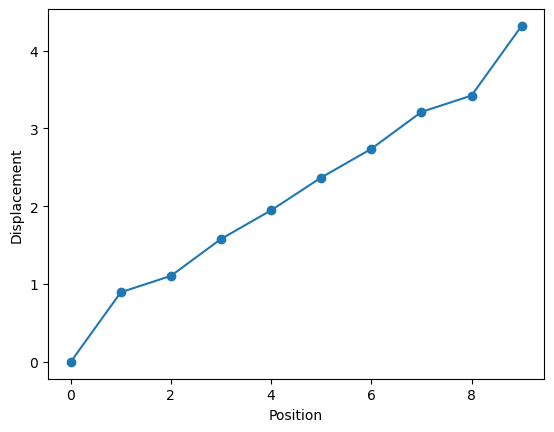

In [32]:
import scipy.sparse as sp
import scipy.sparse.linalg as spla

k_function = lambda x : 1.
k_parallel_function = lambda x : 1.

connectivity_table = compute_connectivity_table(n_dof)
add_parallel_spring(connectivity_table, offset)

sparse_stiffness_matrix_data, F = compute_K_F_sparse(n_dof, connectivity_table, f_ext)

K = apply_boundary_condition_sparse(sparse_stiffness_matrix_data)

U = spla.spsolve(K, F)

plt.plot(U, "o-")
plt.xlabel("Position")
plt.ylabel("Displacement")

On étudie enfin l'impact de la largeur de bande sur le temps de résolution du problème considéré. Pour cela en représente le temps de calcul en fonction du nombre de degrés de liberté du système, pour différents offset.

env: OMP_NUM_THREADS=1


Text(0, 0.5, 'Computation time (s)')

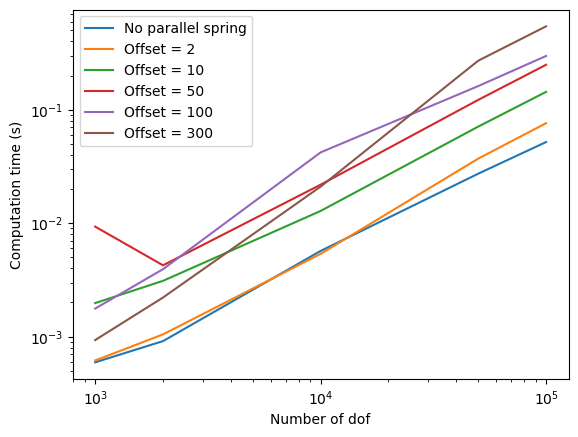

In [33]:
%env OMP_NUM_THREADS=1

import time


n_dof_list = [1000, 2000, 10000, 50000, 100000]
offset_list = [2, 10, 50, 100, 300]
f_ext = 1.

computation_time_list = list()

#Série
for n_dof in n_dof_list:
    connectivity_table = compute_connectivity_table(n_dof)
    sparse_stiffness_matrix_data, F = compute_K_F_sparse(n_dof, connectivity_table, f_ext)
    K = apply_boundary_condition_sparse(sparse_stiffness_matrix_data)
        
    computation_time_begin = time.time()
    U = spla.spsolve(K, F)
    computation_time_end = time.time()
    
    computation_time_list.append(computation_time_end - computation_time_begin)

plt.loglog(n_dof_list, computation_time_list, label="No parallel spring")

#Parallèle
for offset in offset_list : 
    computation_time_list = list()
    for n_dof in n_dof_list:
        connectivity_table = compute_connectivity_table(n_dof)
        add_parallel_spring(connectivity_table, offset)
        sparse_stiffness_matrix_data, F = compute_K_F_sparse(n_dof, connectivity_table, f_ext)
        K = apply_boundary_condition_sparse(sparse_stiffness_matrix_data)
                
        computation_time_begin = time.time()
        U = spla.spsolve(K, F)
        computation_time_end = time.time()

        computation_time_list.append(computation_time_end - computation_time_begin)

    plt.loglog(n_dof_list, computation_time_list, label="Offset = " + str(offset))
    
plt.legend()
plt.xlabel("Number of dof")
plt.ylabel("Computation time (s)")


On constate bien que globalement le temps de calcul augmente avec la largeur de bande.